In [63]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# adds commas to large nums
pd.options.display.float_format = '{:,.2f}'.format

# seaborn plot styles
sns.set_style('darkgrid')
sns.set_context('talk')

In [64]:
# load in cleaned dataset
df = pd.read_csv('data/final.csv', index_col=0)
df.shape

(2156, 13)

# Genre:

In [65]:
# get list of all genres in df['genre']
genres = sorted(list(set([genre for genres in df['genre'] if isinstance(genres, str) for genre in genres.split()])))
genres.remove('TV')
genres.remove('movie')

# add binary genre cols
for genre in genres:
    df.loc[:, genre] = df['genre'].apply(lambda x: 1 if genre in x.split() else 0)

In [66]:
# get counts of all genres
genre_counts = df.iloc[:, 13:].sum().sort_index().to_frame()
genre_counts.columns = ['count']

# the chance that a movie in our datset is classified as that genre
genre_counts['percent'] = (genre_counts['count'] / df.shape[0])

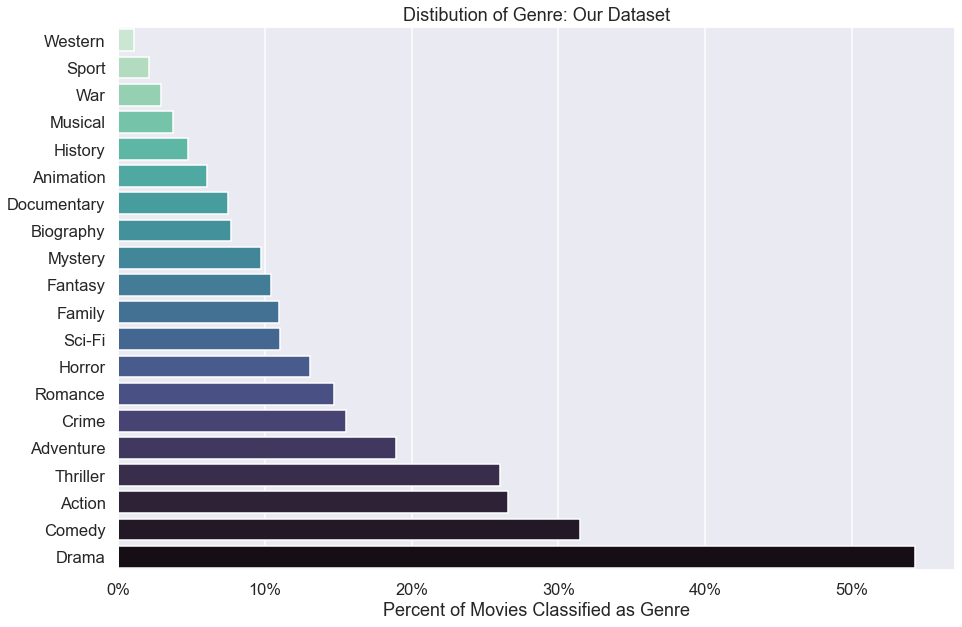

In [67]:
plt.figure(figsize=(15, 10))

sns.barplot(y=genre_counts.sort_values('percent').index, x=genre_counts['percent'].sort_values(), palette='mako_r')

plt.title('Distibution of Genre: Our Dataset')
plt.ylabel('')
plt.xlabel('Percent of Movies Classified as Genre')

plt.xticks(ticks=[0, .10, .20, .30, .40, .50], labels=['0%', '10%', '20%', '30%', '40%', '50%']);

### Compare Median ROI per genre:

In [68]:
# for plotting; seperates mulitple-genre films into multiple rows
df_melted = df.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
df_melted = df_melted[df_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

In [69]:
# get median roi for each genre
genre_medians = df_melted.groupby('genre')['roi'].median().to_frame()
genre_medians.columns = ['median_roi']
genre_medians = genre_medians.sort_values('median_roi')
genre_medians.sort_values('median_roi', ascending=False).T

genre,Animation,Family,Adventure,Sci-Fi,Mystery,Horror,Fantasy,Comedy,Action,Biography,Romance,Thriller,Musical,Crime,Drama,Documentary,Sport,War,History,Western
median_roi,1.80,1.46,1.40,1.37,1.36,1.36,1.25,1.21,1.17,0.87,0.86,0.80,0.65,0.61,0.61,0.47,0.47,0.38,0.34,0.18


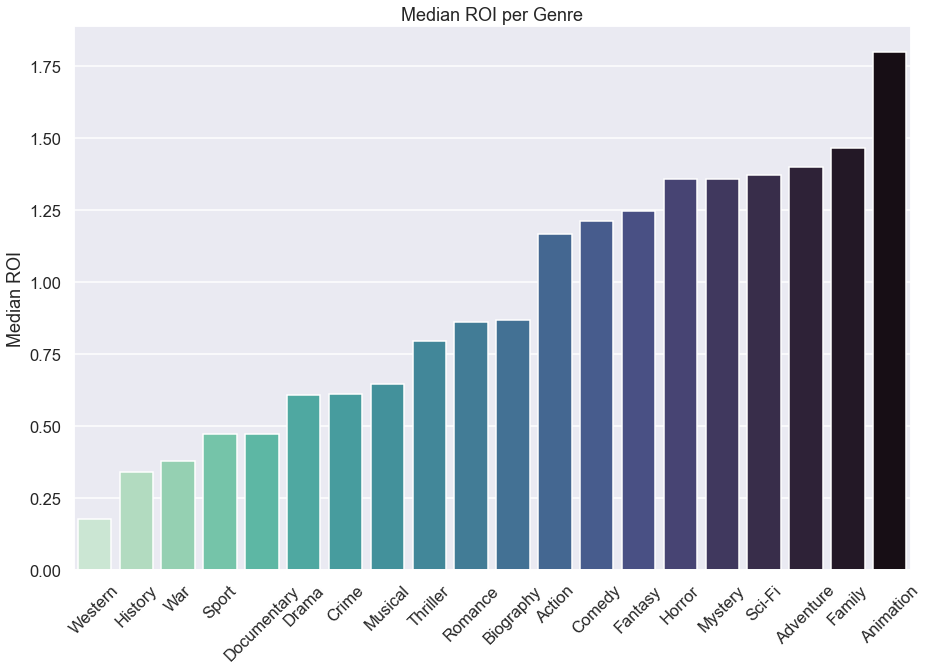

In [70]:
plt.figure(figsize=(15, 10))

sns.barplot(x=genre_medians.sort_values('median_roi').index, y=genre_medians.sort_values(
    'median_roi')['median_roi'], palette='mako_r')

plt.title('Median ROI per Genre')
plt.ylabel('Median ROI')
plt.xlabel('')
plt.xticks(rotation=45)

plt.savefig('plots/med_roi_genre');

### Bin movies by ROI:
- positive (ROI > 0)
- negative (ROI < 0)
- 100% profit (ROI > 1)

In [71]:
made_money = df.query(" roi > 0 ")
lost_money = df.query(" roi < 0 ")

print(f'We have {made_money.shape[0]} ({made_money.shape[0]/df.shape[0]*100:.1f}%) movies that made money.')
print(f'We have {lost_money.shape[0]} ({lost_money.shape[0]/df.shape[0]*100:.1f}%) movies that lost money.')

We have 1479 (68.6%) movies that made money.
We have 677 (31.4%) movies that lost money.


### Movies that made money:

In [72]:
pos_melted = made_money.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
pos_melted = pos_melted[pos_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

pos_medians = pos_melted.groupby('genre')['roi'].median().to_frame()
pos_medians.columns = ['median_roi']
pos_medians = pos_medians.sort_values('median_roi')

pos_medians.sort_values('median_roi', ascending=False).T

genre,Musical,Horror,Biography,Mystery,Animation,Sci-Fi,War,Romance,Comedy,Documentary,Drama,Thriller,Adventure,Action,Fantasy,Family,Western,Crime,History,Sport
median_roi,3.36,2.84,2.26,2.23,2.21,2.20,2.18,2.11,2.04,1.97,1.93,1.91,1.89,1.83,1.75,1.75,1.73,1.56,1.42,1.24


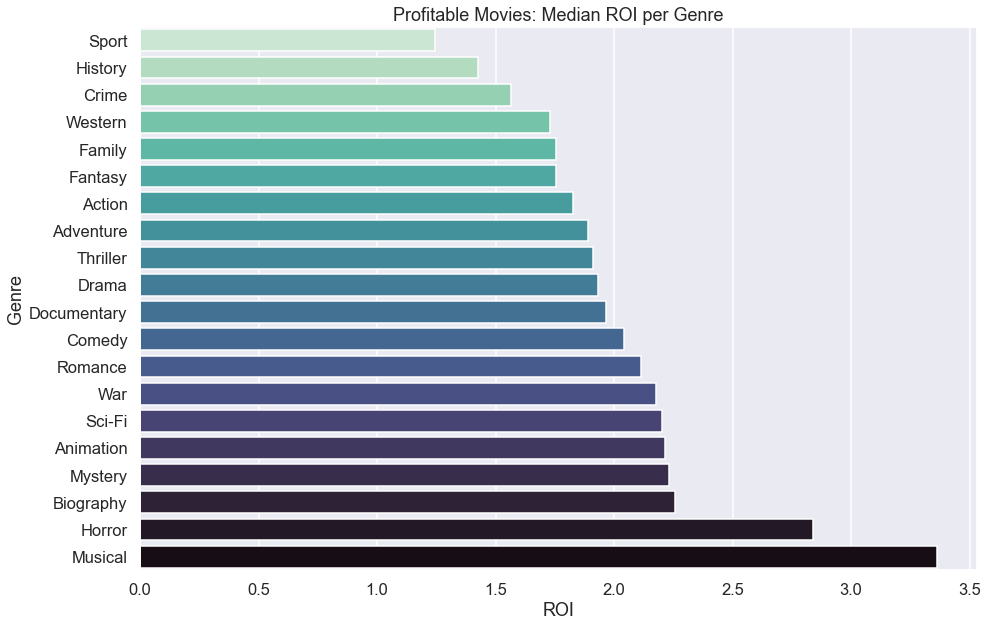

In [73]:
plt.figure(figsize=(15, 10))

sns.barplot(y=pos_medians.index, x=pos_medians['median_roi'], palette='mako_r')

plt.title('Profitable Movies: Median ROI per Genre')
plt.ylabel('Genre')
plt.xlabel('ROI');

In [74]:
# counts of each genre from made_money
pos_counts = pos_melted.groupby('genre')['roi'].count().to_frame().sort_values('roi', ascending=False)
pos_counts.columns = ['count']

# shows what percent of the movies that made money pertained to each genre -> p(genre | profitable)
pos_counts['percent'] = pos_counts['count'] / made_money.shape[0]

### Movies that lost money:

In [75]:
# lost money (negative ROI)
neg_melted = lost_money.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
neg_melted = neg_melted[neg_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

neg_medians = neg_melted.groupby('genre')['roi'].median().to_frame()
neg_medians.columns = ['median_roi']
neg_medians = neg_medians.sort_values('median_roi', ascending=False)

neg_medians.sort_values('median_roi').T

genre,War,Sport,Western,Family,Horror,Documentary,Comedy,Romance,Drama,Action,Biography,Mystery,Thriller,Crime,Sci-Fi,History,Animation,Musical,Fantasy,Adventure
median_roi,-0.78,-0.75,-0.75,-0.74,-0.74,-0.73,-0.71,-0.69,-0.69,-0.69,-0.68,-0.67,-0.67,-0.65,-0.63,-0.62,-0.60,-0.58,-0.56,-0.51


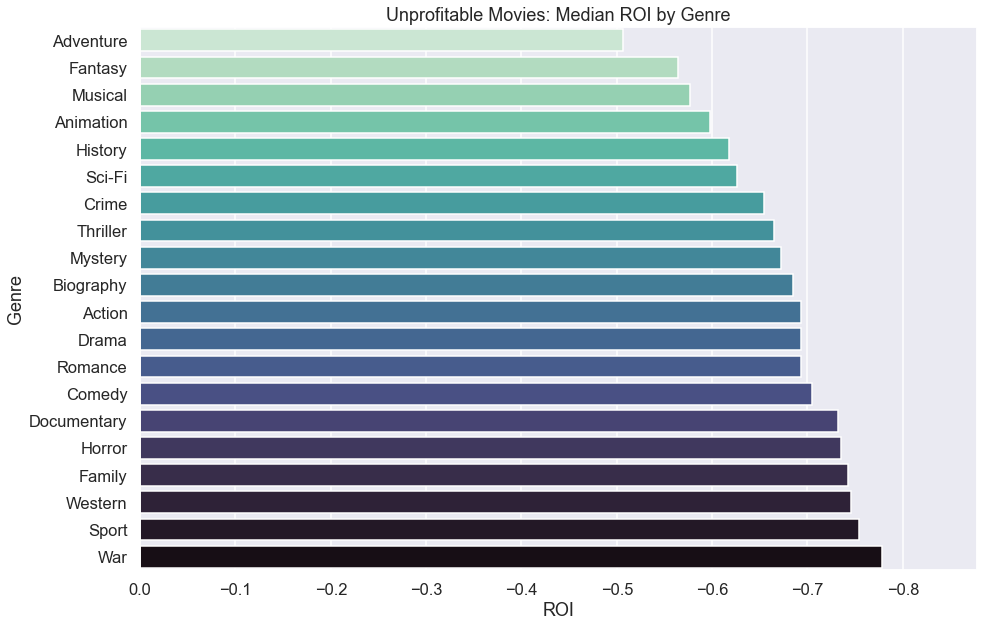

In [76]:
plt.figure(figsize=(15, 10))

plot = sns.barplot(y=neg_medians.index, x=neg_medians['median_roi'], palette='mako_r')
plot.set_xlim(0, min(neg_medians['median_roi']) - 0.1)

plt.title('Unprofitable Movies: Median ROI by Genre')
plt.ylabel('Genre')
plt.xlabel('ROI');

In [77]:
# counts of each genre from lost_money
neg_counts = neg_melted.groupby('genre')['roi'].count().to_frame().sort_values('roi', ascending=False)
neg_counts.columns = ['count']

# shows what percent of the movies that lost money pertained to each genre -> p(genre | unprofitable)
neg_counts['percent'] = neg_counts['count'] / lost_money.shape[0]

neg_counts.T

genre,Drama,Thriller,Comedy,Action,Crime,Romance,Horror,Adventure,Documentary,Biography,Sci-Fi,Mystery,History,Fantasy,Family,Musical,War,Sport,Animation,Western
count,431.00,183.00,181.00,149.00,127.00,105.00,81.00,79.00,65.00,62.00,60.00,56.00,45.00,45.00,37.00,30.00,29.00,20.00,17.00,12.00
percent,0.64,0.27,0.27,0.22,0.19,0.16,0.12,0.12,0.10,0.09,0.09,0.08,0.07,0.07,0.05,0.04,0.04,0.03,0.03,0.02


### What is each genre's chance of being profitable? (profitable | genre)
p(profitable | genre) = (p(genre | profitable) * p(profitable)) / p(genre)

In [78]:
p_genre_given_prof = pos_counts['percent'].sort_index()
p_prof = made_money.shape[0]/df.shape[0]
p_genre = genre_counts['percent'].sort_index()

p_prof_given_genre = ((p_genre_given_prof * p_prof) / p_genre).sort_values(ascending=False).to_frame()

# add a rank col
p_prof_given_genre['percent_rank'] = list(range(1, 21))

p_prof_given_genre.T

genre,Animation,Family,Adventure,Fantasy,Sci-Fi,Action,Comedy,Mystery,Horror,Thriller,Romance,Drama,Musical,Biography,Crime,Documentary,History,Sport,War,Western
percent,0.87,0.84,0.81,0.80,0.75,0.74,0.73,0.73,0.71,0.67,0.67,0.63,0.63,0.63,0.62,0.60,0.56,0.56,0.54,0.50
percent_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [79]:
# get median roi for each genre to counter outliers
genre_roi_med = df_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
genre_roi_med.columns = ['median_roi']

# add a rank col
genre_roi_med['median_rank'] = list(range(1, 21))

genre_roi_med.sort_values('median_roi', ascending=False).T

genre,Animation,Family,Adventure,Sci-Fi,Mystery,Horror,Fantasy,Comedy,Action,Biography,Romance,Thriller,Musical,Crime,Drama,Documentary,Sport,War,History,Western
median_roi,1.80,1.46,1.40,1.37,1.36,1.36,1.25,1.21,1.17,0.87,0.86,0.80,0.65,0.61,0.61,0.47,0.47,0.38,0.34,0.18
median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [80]:
# combine median_roi with percent_profitable
combined1 = p_prof_given_genre.merge(genre_roi_med, on='genre')

# composite rank
combined1['agg_rank'] = (combined1['percent'] * combined1['median_roi'])

combined1.T #.sort_values('agg_rank')

genre,Animation,Family,Adventure,Fantasy,Sci-Fi,Action,Comedy,Mystery,Horror,Thriller,Romance,Drama,Musical,Biography,Crime,Documentary,History,Sport,War,Western
percent,0.87,0.84,0.81,0.80,0.75,0.74,0.73,0.73,0.71,0.67,0.67,0.63,0.63,0.63,0.62,0.60,0.56,0.56,0.54,0.50
percent_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00
median_roi,1.80,1.46,1.40,1.25,1.37,1.17,1.21,1.36,1.36,0.80,0.86,0.61,0.65,0.87,0.61,0.47,0.34,0.47,0.38,0.18
median_rank,1.00,2.00,3.00,7.00,4.00,9.00,8.00,5.00,6.00,12.00,11.00,15.00,13.00,10.00,14.00,16.00,19.00,17.00,18.00,20.00
agg_rank,1.56,1.23,1.13,1.00,1.03,0.86,0.89,1.00,0.97,0.54,0.57,0.38,0.41,0.54,0.38,0.28,0.19,0.26,0.21,0.09


### Observations from looking at the genres of ALL movies:
- Animation performs very well. Safest pick with 87% chance of being profitable and it also has the highest median ROI at 1.8.
- Family, Adventure, and Fantasy are also good recs with over 80% chance of profit and median ROI ranks of 2, 3, and 7 respectively.
- Western is by far the worst genre. Ranks 20th in both metrics (only 50% chance of profit and 0.18 median ROI).

### Investigate genre by production_cost:

In [81]:
# movies with production cost less than 10 mil
prod_small = df.query("production_budget < 1e7")
prod_small.shape

(628, 33)

In [82]:
# seperates mulitple-genre films into multiple rows
small_melted = prod_small.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
small_melted = small_melted[small_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

# get median ROi for each genre in prod_small
small_med = small_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
small_med.columns = ['small_median_roi']
small_med['small_median_rank'] = list(range(1, 21))

small_med.T

genre,Animation,Horror,Mystery,Sci-Fi,Biography,Romance,Thriller,Comedy,Family,Fantasy,Drama,Musical,Documentary,Adventure,History,Crime,Western,Action,Sport,War
small_median_roi,2.73,2.29,1.96,0.74,0.68,0.58,0.48,0.48,0.30,0.24,0.21,0.21,0.16,-0.06,-0.11,-0.25,-0.40,-0.42,-0.45,-0.70
small_median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [83]:
# movies with production cost between 10 mil and 100 mil
prod_med = df.query("1e7 <= production_budget < 1e8")
prod_med.shape

(1287, 33)

In [84]:
# seperates mulitple-genre films into multiple rows
med_melted = prod_med.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
med_melted = med_melted[med_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

# get median ROi for each genre in prod_med
med_med = med_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
med_med.columns = ['med_median_roi']
med_med['med_median_rank'] = list(range(1, 21))

med_med.T

genre,Animation,Family,Musical,Comedy,Mystery,Fantasy,Horror,Adventure,Biography,Romance,Sci-Fi,Action,Thriller,Drama,Sport,Crime,Documentary,War,History,Western
med_median_roi,1.53,1.36,1.29,1.29,1.20,1.04,1.04,0.95,0.87,0.86,0.82,0.77,0.74,0.74,0.68,0.63,0.48,0.43,0.37,0.20
med_median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [85]:
# movies with production cost over 100 mil
prod_big = df.query("production_budget >= 1e8")
prod_big.shape

(241, 33)

In [86]:
# seperates mulitple-genre films into multiple rows
big_melted = prod_big.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
big_melted = big_melted[big_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

# get median ROi for each genre in prod_big
big_med = big_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
big_med.columns = ['big_median_roi']
big_med['big_median_rank'] = list(range(1, 21))

big_med.T

genre,Sport,Crime,Biography,Documentary,Animation,Sci-Fi,Comedy,War,Action,Adventure,Western,Fantasy,Family,Thriller,Romance,Musical,Drama,Mystery,Horror,History
big_median_roi,3.88,2.92,2.90,2.79,2.09,2.05,2.01,2.01,1.95,1.95,1.88,1.88,1.79,1.79,1.77,1.75,1.71,1.64,1.45,-0.10
big_median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [87]:
combined2 = small_med.merge(med_med, on='genre').merge(big_med, on='genre')

# add composite rank
combined2['agg_rank'] = (combined2['small_median_rank'] + combined2['med_median_rank'] + combined2['big_median_rank']) / 3

combined2.sort_values('agg_rank').T

genre,Animation,Biography,Comedy,Sci-Fi,Family,Mystery,Fantasy,Horror,Romance,Musical,Adventure,Documentary,Crime,Thriller,Sport,Action,Drama,War,Western,History
small_median_roi,2.73,0.68,0.48,0.74,0.30,1.96,0.24,2.29,0.58,0.21,-0.06,0.16,-0.25,0.48,-0.45,-0.42,0.21,-0.70,-0.40,-0.11
small_median_rank,1.00,5.00,8.00,4.00,9.00,3.00,10.00,2.00,6.00,12.00,14.00,13.00,16.00,7.00,19.00,18.00,11.00,20.00,17.00,15.00
med_median_roi,1.53,0.87,1.29,0.82,1.36,1.20,1.04,1.04,0.86,1.29,0.95,0.48,0.63,0.74,0.68,0.77,0.74,0.43,0.20,0.37
med_median_rank,1.00,9.00,4.00,11.00,2.00,5.00,6.00,7.00,10.00,3.00,8.00,17.00,16.00,13.00,15.00,12.00,14.00,18.00,20.00,19.00
big_median_roi,2.09,2.90,2.01,2.05,1.79,1.64,1.88,1.45,1.77,1.75,1.95,2.79,2.92,1.79,3.88,1.95,1.71,2.01,1.88,-0.10
big_median_rank,5.00,3.00,7.00,6.00,13.00,18.00,12.00,19.00,15.00,16.00,10.00,4.00,2.00,14.00,1.00,9.00,17.00,8.00,11.00,20.00
agg_rank,2.33,5.67,6.33,7.00,8.00,8.67,9.33,9.33,10.33,10.33,10.67,11.33,11.33,11.33,11.67,13.00,14.00,15.33,16.00,18.00


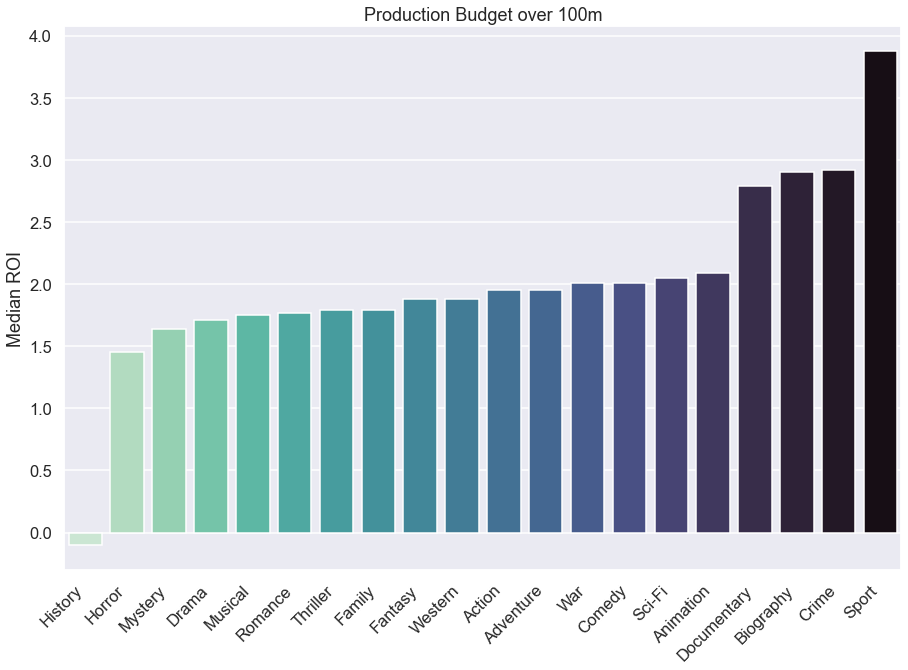

In [88]:
# plot for big production films
plt.figure(figsize=(15, 10))

sns.barplot(x=combined2.sort_values('big_median_roi').index, y=combined2.sort_values('big_median_roi')['big_median_roi'], palette='mako_r')

plt.title('Production Budget over 100m')
plt.ylabel('Median ROI')
plt.xlabel('')

plt.xticks(rotation=45)

for label in plt.gca().get_xticklabels():
    label.set_horizontalalignment('right')
    
plt.savefig('plots/roi_over_100', dpi=150);

### Observations from different production costs:
- Small - Animation performs the best by quite a large margin (0.44 median ROI greater than #2 Horror).
- Medium - Animation slightly outperms Family.
- Large - Sport has much higher median ROI (0.96 higher) than even the second closest Genre.

# Director:

In [89]:
# Fill null values in Director(primary_name) 'Unknown'
df.loc[:, ['primary_name']] = df.loc[:, ['primary_name']].fillna(value = 'Unknown', axis = 1)

# Creating new column for Director Experience (# of movies in curated df)
dir_counts = df['primary_name'].value_counts()
df['director_experience'] = df['primary_name'].map(dir_counts)

# Getting rid of 'Unknown' values
unk_dir_mask = df['primary_name'].isin(['Unknown'])
df = df.loc[~unk_dir_mask]

# Curating df for director analysis
dir_df = df[['primary_name', 'director_experience', 'title', 'production_budget', 'genre', 'roi']].copy()

In [90]:
# Initial Director Experience filter
experience_filter = [1, 2]

# 3 movies or less
inexp_dir_mask = dir_df['director_experience'].isin(experience_filter)

# keep directors with 3 movies or more
experienced_dir_df = dir_df.loc[~inexp_dir_mask].reset_index(drop = True)

In [91]:
# Creation of 'Golden List' aka 'Top 20 Directors by Avg. ROI'
golden_list = experienced_dir_df.groupby('primary_name').roi.mean().reset_index().sort_values(
    by='roi', ascending = False).head(20)

# Creation of alphabetically ordered list of directors for manual calculations
ordered_exp_dir_list = experienced_dir_df.sort_values(by =['director_experience', 'roi'], ascending = [False, False]).groupby('primary_name')

In [92]:
# very large print statement to manually view some data
# for key, item in ordered_exp_dir_list:
#     print(ordered_exp_dir_list.get_group(key), "\n\n")

In [93]:
# Manual Entry and Analysis of Golden List Top Performing Genres
top_perf_genre = ['Outlier', 'Outlier', 'Thriller-Horror+Mystery / Action', 'Thriller-Horror/Sci-fi', 'Thriller-Horror/Mystery',
                  'Thriller-Horror+Mystery / Action-Fantasy+Adventure', 'Musical-Drama', 'Outlier', 'Comedy-Romance/Adventure', 
                  'Drama / Romance', 'Adventure-Family+Comedy / Adventure - Crime', 'Comedy-Flex', 'Drama', 
                  'Drama-Action/Comedy', 'Sci-fi-Action/Thriller', 'Outlier', 'Drama-Sport/Crime', 'X-Men / Music', 
                  'Adventure-Family/Drama / Animation', 'Comedy-Romance/Adventure / Animation']
golden_list['top_performing_genre'] = top_perf_genre

# add average budget col
golden_list = golden_list.merge(ordered_exp_dir_list.mean().sort_values(
    'roi', ascending=False).head(20)['production_budget'].to_frame(), on='primary_name')
golden_list.columns = ['primary_name', 'roi', 'top_performing_genre', 'average budget']

In [94]:
# Hardcoding values for 'Chance of Positive ROI' Calculation
golden_list['num_pos_mov'] =         [2, 4, 4, 5, 4, 3, 3, 3, 3, 3, 2, 4, 3, 5, 3, 3, 4, 4, 3, 4]
golden_list['director_experience'] = [6, 4, 4, 5, 4, 3, 3, 3, 3, 3, 3, 4, 3, 6, 3, 4, 5, 4, 3, 4]

In [95]:
# Chance of success based on genre, values from Genre table
golden_list['genre_values'] = [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.6, 0.68, 0.67, 0.58, 0.76, 0.67, 0.58, 0.58, 0.68, 0.52, 
                               0.58, 0.60, 0.83, 0.83]

#Calculation and Creation of 'Chance of Pos ROI' Column
golden_list['Chance of Pos ROI (%)'] = ((golden_list.genre_values)*((golden_list.num_pos_mov)/(golden_list.director_experience)))*100

In [96]:
# look at directors that match our top genre recommendations
golden_list.query(" genre_values > 0.7 ")

,primary_name,roi,top_performing_genre,average budget,num_pos_mov,director_experience,genre_values,Chance of Pos ROI (%)
10,Jon Favreau,6.20,Adventure-Family+Comedy / Adventure - Crime,"141,433,333.33",2,3,0.76,50.67
18,Eli Roth,4.90,Adventure-Family/Drama / Animation,"11,000,000.00",3,3,0.83,83.00
19,Will Gluck,4.70,Comedy-Romance/Adventure / Animation,"39,500,000.00",4,4,0.83,83.00


### Observations of Director:
- Jon Favreau, Eli Roth, and Will Gluck are all great recommendations
- We decided to go with Jon Favreau, as we have domain knowledge of outside of many succesful films he has created (Iron Man, Lion King, Mandalorian, etc.)

# Release Date (By Season):

In [97]:
#create subset
month = df[['title', 'roi','month']].copy()

In [98]:
#create month map
month_map = {
    1.0: 'January',
    2.0: 'February',
    3.0: 'March',
    4.0: 'April',
    5.0: 'May',
    6.0: 'June',
    7.0: 'July',
    8.0: 'August',
    9.0: 'September',
    10.0: 'October',
    11.0: 'November',
    12.0: 'December'
}

month['official_month'] = month['month'].map(month_map)

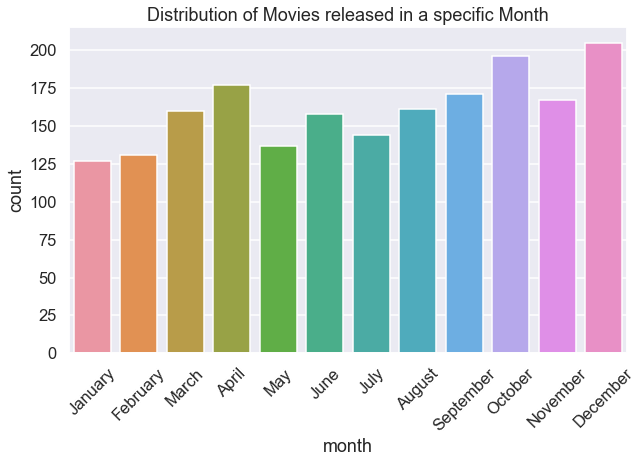

In [99]:
month_counts = month['official_month'].value_counts().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

plt.figure(figsize=(10, 6))

sns.barplot(x=month_counts.index, y=month_counts.values)
plt.xlabel('month')
plt.ylabel('count') 
plt.title('Distribution of Movies released in a specific Month')

plt.xticks(rotation=45);

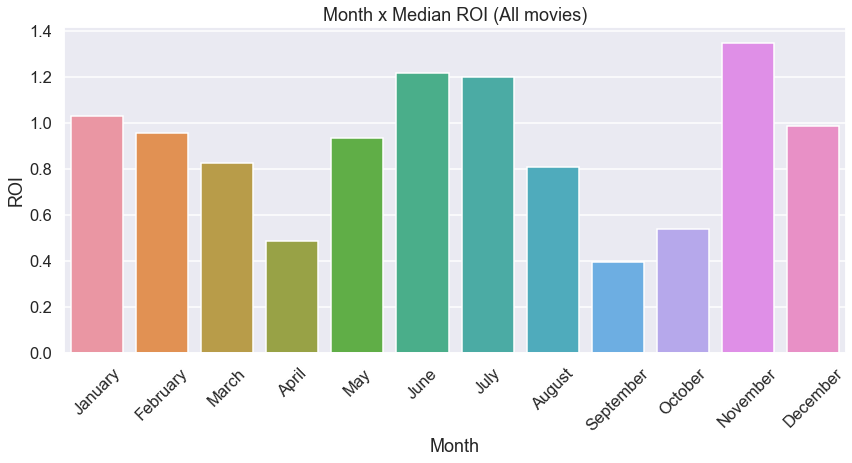

In [100]:
#month order 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 
               'December']

plt.figure(figsize=(14, 6))

sns.barplot(x = 'official_month', y = 'roi', data = month, ci = None, order = month_order, estimator=np.median)
plt.title('Month x Median ROI (All movies)')
plt.xlabel('Month')
plt.ylabel('ROI')

plt.xticks(rotation=45);

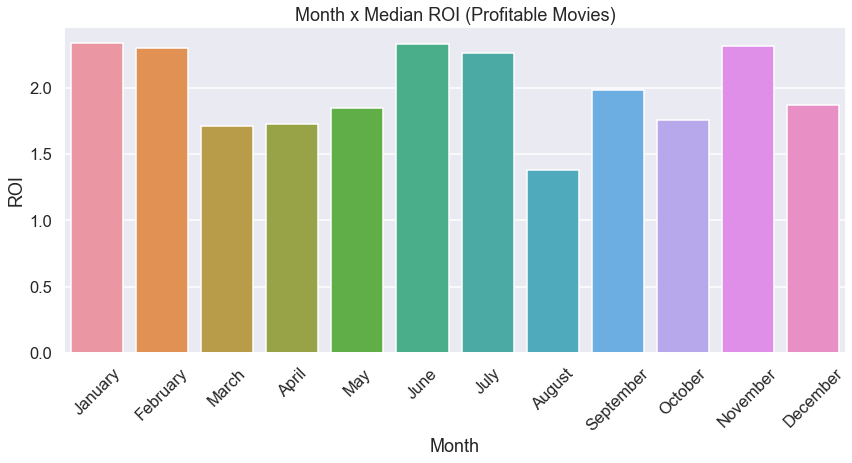

In [101]:
# subset positive ROI
month_pos = month[month['roi'] > 0]

plt.figure(figsize=(14, 6))

sns.barplot(x = 'official_month', y = 'roi', data = month_pos, ci = None, order = month_order, estimator=np.median)
plt.title('Month x Median ROI (Profitable Movies)')
plt.xlabel('Month')
plt.ylabel('ROI')

plt.xticks(rotation=45);

- June, July, and November seem to perform best

In [102]:
#ANOVA test for roi and month
cat = [group['roi'] for name, group in month.groupby('official_month')]
f_stat, pval = stats.f_oneway(*cat)

print(f'p-val: {pval}')

alpha = 0.05 
if pval < alpha:
    print("statistically significant")
else:
    print("not statistically significant")

p-val: 0.629127889234601
not statistically significant


### Group months by season:

In [103]:
def season(month):
    if 3.0 <= month <= 5.0: #March 1 to May 31
        return "Spring"
    elif 6.0 <= month <= 8.0: #June 1 to August 31
        return "Summer"
    elif 9.0 <= month <= 11.0: #September 1 to November 30
        return "Autumn"
    else:
        return "Winter" # December 1 to February 28
    

#create season column
month['season'] = month['month'].apply(season)
month_pos['season'] = month_pos['month'].apply(season)

<ipython-input-103-bd60c470d795>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_pos['season'] = month_pos['month'].apply(season)


In [104]:
# median ROIs by season for ALL movies
month.groupby('season').median()[['roi']]

,roi
season,
Autumn,0.75
Spring,0.77
Summer,1.10
Winter,0.99


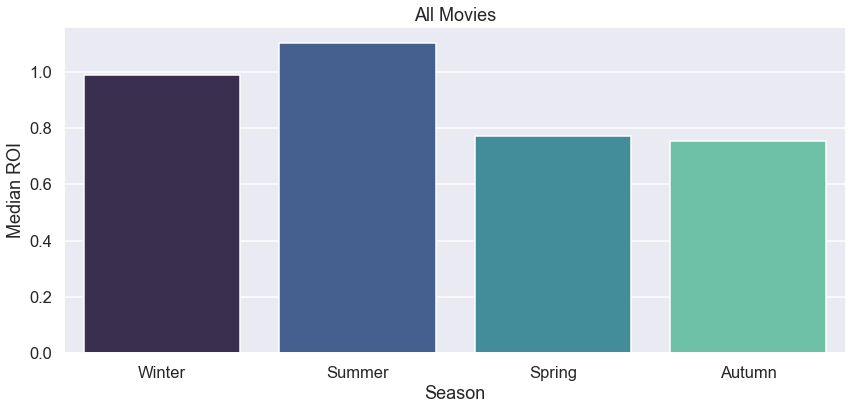

In [105]:
season_ord = ['Winter', 'Summer', 'Spring', 'Autumn']

plt.figure(figsize = (14,6))

sns.barplot(x = 'season', y = 'roi', data = month, ci = False, order = season_ord, estimator=np.median, palette='mako')
plt.xlabel('Season')
plt.ylabel('Median ROI')
plt.title('All Movies')

plt.savefig('plots/med_roi_season');

In [106]:
# median ROIs by season for profitable movies
month_pos.groupby('season').median()[['roi']]

,roi
season,
Autumn,1.98
Spring,1.77
Summer,2.08
Winter,2.22


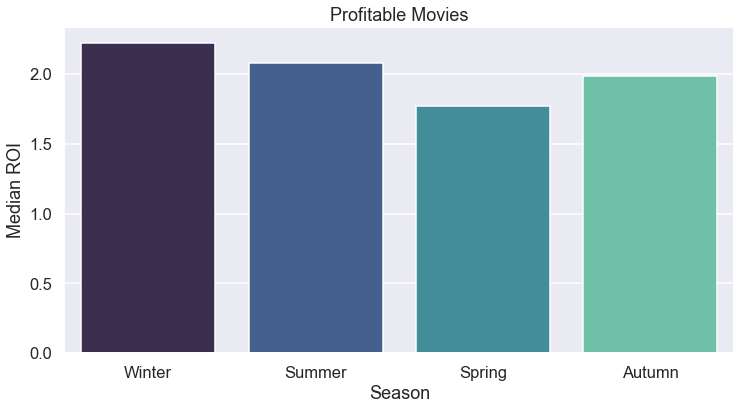

In [107]:
plt.figure(figsize = (12,6))

sns.barplot(x = 'season', y = 'roi', data = month_pos, ci = False, order = season_ord, estimator=np.median, palette='mako')
plt.xlabel('Season')
plt.ylabel('Median ROI')
plt.title('Profitable Movies');

### Analyze season for 3 different production costs:

In [108]:
# under 10m
under_ten_month = prod_small[['title', 'roi','month']].copy()
under_ten_month['season'] = under_ten_month['month'].apply(season)

# 10m to 100m
ten_hundo_month = prod_med[['title', 'roi','month']].copy()
ten_hundo_month['season'] = ten_hundo_month['month'].apply(season)

#over 100 mill
over_hundo_month = prod_big[['title', 'roi','month']].copy()
over_hundo_month['season'] = over_hundo_month['month'].apply(season)

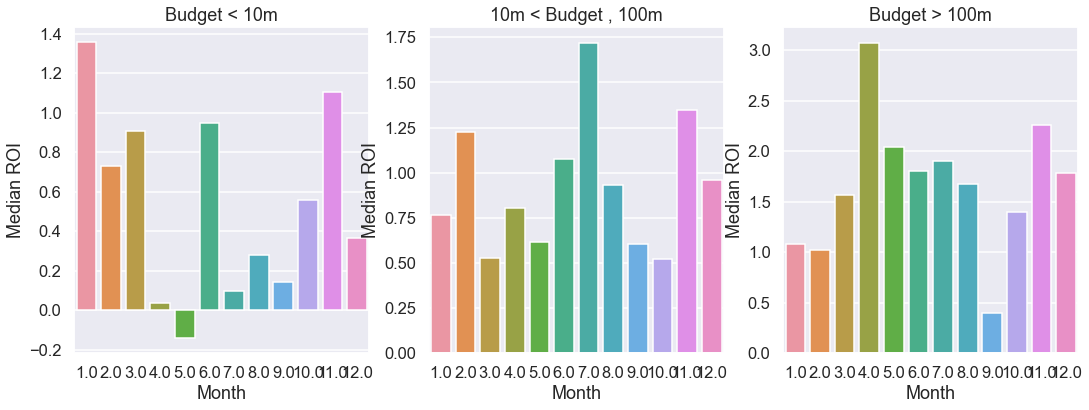

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#plot 1
sns.barplot(x = 'month', y = 'roi', data = under_ten_month, ci = None, ax = axes[0], estimator=np.median)
axes[0].set_title('Budget < 10m')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Median ROI')

#plot 2
sns.barplot(x ='month', y ='roi', data = ten_hundo_month, ci=None, ax=axes[1], estimator=np.median)
axes[1].set_title('10m < Budget , 100m')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Median ROI')

#plot 3
sns.barplot(x = 'month', y ='roi', data = over_hundo_month, ci=None, ax=axes[2], estimator=np.median)
axes[2].set_title('Budget > 100m')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Median ROI');

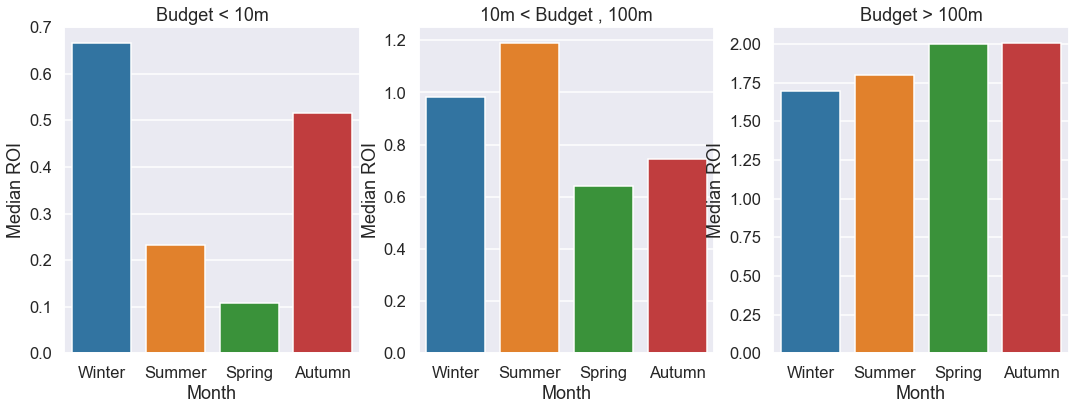

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#plot 1
sns.barplot(x='season', y='roi', data=under_ten_month, ci=None, ax=axes[0], estimator=np.median, order=season_ord)
axes[0].set_title('Budget < 10m')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Median ROI')

#plot 2
sns.barplot(x='season', y='roi', data=ten_hundo_month, ci=None, ax=axes[1], estimator=np.median, order=season_ord)
axes[1].set_title('10m < Budget , 100m')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Median ROI')

#plot 3
sns.barplot(x='season', y='roi', data=over_hundo_month, ci=None, ax=axes[2], estimator=np.median, order=season_ord)
axes[2].set_title('Budget > 100m')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Median ROI');

### Calculate probability of each season being profitable:

In [111]:
season_counts = month['season'].value_counts()
season_probabilities = season_counts / len(df)

print("Probability of a movie being debuted in each season:")
print(season_probabilities)

Probability of a movie being debuted in each season:
Autumn   0.28
Spring   0.25
Winter   0.24
Summer   0.24
Name: season, dtype: float64


In [112]:
 # conditional prob for season and positive ROI
positive_roi_probabilities = {}
for season in month['season'].unique():
    szn_dat = month[month['season'] == season]
    pos_roi = (szn_dat['roi'] > 0).sum()
    tot_movies = len(szn_dat)
    positive_roi_probabilities[season] = pos_roi / tot_movies

# conditional prob for season and negative ROI
negative_roi_probabilities = {}
for season in month['season'].unique():
    szn_dat = month[month['season'] == season]
    neg_roi = (szn_dat['roi'] < 0).sum()
    total_movies = len(szn_dat)
    negative_roi_probabilities[season] = neg_roi / total_movies

print("Prob of a positive ROI given each season:")
print(positive_roi_probabilities)

print("\nProb of a negative ROI given each season:")
print(negative_roi_probabilities)

Prob of a positive ROI given each season:
{'Winter': 0.6803455723542117, 'Summer': 0.7084233261339092, 'Spring': 0.6687763713080169, 'Autumn': 0.6554307116104869}

Prob of a negative ROI given each season:
{'Winter': 0.31965442764578833, 'Summer': 0.2915766738660907, 'Spring': 0.33122362869198313, 'Autumn': 0.3445692883895131}


### Observations of release season:
- Summer boasted highest median ROI for both all movies (1.2) and profitable movies (2.19). Winter was a close second in both.
- Summer also had highest chance of being profitable at 72%. Winter was close second at 69%.
- Spring overall seems to be the worst (67% chance of profit, worst in short and medium-length films).

# Runtime
- short films - less than 40 min
- medium films - 40 - 150 min
- long films - greater than 150 min

In [113]:
# runtime subset
runtime = df[['title','runtime', 'roi']].dropna()

short_count = len(runtime[runtime['runtime'] < 40])
med_count = len((runtime[(runtime['runtime'] >= 40) & (runtime['runtime'] <= 150)]))
long_count = len(runtime[runtime['runtime'] > 150])

print(f'Short movies: {short_count}\nAvg movies: {med_count}\nLong movies: {long_count}')

Short movies: 22
Avg movies: 1754
Long movies: 36


In [114]:
# group 3 runtime caregories
def runtime_cat(runtime):
    if 0.0 <= runtime <= 40.0:
        return "short"
    elif 41.0 <= runtime <= 150.0:
        return "medium"
    else:
        return "long"
    
# apply and create new column
runtime['runtime_length'] = runtime['runtime'].apply(runtime_cat)

In [115]:
runtime.groupby('runtime_length').median()

,runtime,roi
runtime_length,,
long,161.00,2.12
medium,103.00,0.91
short,9.50,0.44


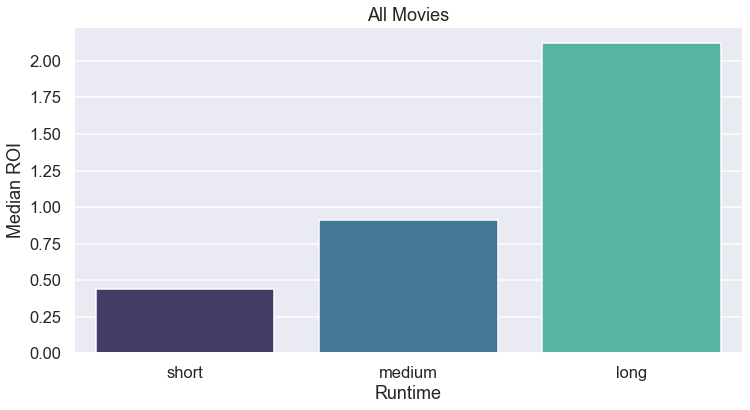

In [116]:
runtime_ord = ['short', 'medium', 'long']

plt.figure(figsize = (12,6))
sns.barplot(x = 'runtime_length', y = 'roi', data = runtime, ci = False, estimator=np.median, order=runtime_ord, palette='mako')

plt.xlabel('Runtime')
plt.ylabel('Median ROI')
plt.title('All Movies')

plt.savefig('plots/med_roi_runtime');

- Medium-length films have significantly larger median ROI.

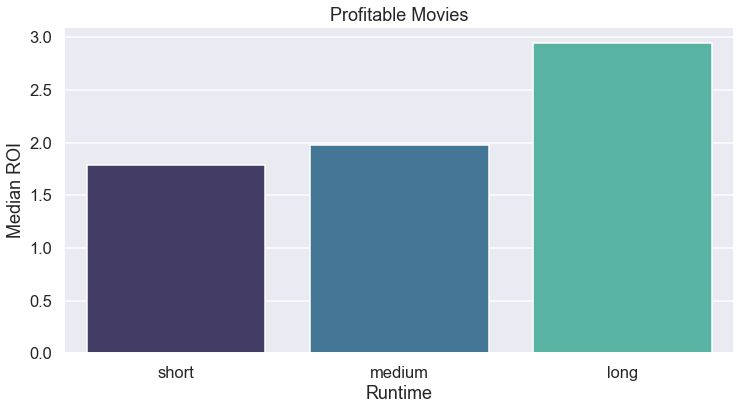

In [117]:
#movies that made money
pos_roi_rt = runtime[runtime['roi'] > 0]

plt.figure(figsize = (12,6))
sns.barplot(x = 'runtime_length', y = 'roi', data = pos_roi_rt, ci = False, estimator=np.median, order=runtime_ord, palette='mako')

plt.xlabel('Runtime')
plt.ylabel('Median ROI')
plt.title('Profitable Movies');

In [118]:
# count the number of movies in each category
pos_short = len(pos_roi_rt[(pos_roi_rt['runtime_length'] == 'short')])
short = len(runtime[runtime['runtime_length'] == 'short'])
                    
pos_med = len(pos_roi_rt[(pos_roi_rt['runtime_length'] == 'medium')])
average = len(runtime[runtime['runtime_length'] == 'medium'])

pos_long = len(pos_roi_rt[(pos_roi_rt['runtime_length'] == 'long')])
long = len(runtime[runtime['runtime_length'] == 'long'])


# Total number of movies
total_movies = len(runtime)

In [119]:
#P(Pos|Short)
p_given_short = pos_short / short

#P(pos|average)
p_given_avg = pos_med / average

#P(pos|average)
p_given_long = pos_long / long

print("P(p_positive_roi | p_short):", p_given_short)
print("P(p_positive_roi | p_avg):", p_given_avg)
print("P(p_positive_roi | p_long):", p_given_long)

P(p_positive_roi | p_short): 0.6363636363636364
P(p_positive_roi | p_avg): 0.6807297605473204
P(p_positive_roi | p_long): 0.75


### Observations of Runtime
- Extended-length films boasted the highest median ROI in both overall and profitable comparisons. They also showed to be the safest at 75% chance of profitability.
- Short films performed the worst. Lowest median ROI and least safe at 64%.

# Final recommendations:
### Genre:
- Animation
- Sports for budgets > 100m

### Director:
- Jon Favreau
- Will Gluck

### Season:
- Summer

### Runtime:
- Extended films (> 150 min)